# Calculate fractions of raster classes in polygons

##### Oskar Bäcklin - April 2023


In [ ]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.mask import mask as rasterio_mask
from shapely.geometry import box, mapping
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt 

# Set dict according to landcoverraster
coldict = {
     1:'Paved',
     2:'Building',
     3:'Evergreen Tree',
     4:'Decidous Tree',
     5:'Grass',
     6:'Bare Soil',
     7:'Water', 
}

raster_classes = list(coldict.keys())
raster_classes_name = list(coldict.values())

# Set paths to raster and vectordata
vectordata_in = 'C:/Users/xbacos/OneDrive - University of Gothenburg/Artikel_2/Enkat/PostCode/PostCodeGBG.shp'
raster_fn = 'C:/Users/xbacos/OneDrive - University of Gothenburg/Artikel_2/Enkat/lc/lc.tif'

# Set name of geometry column
geometry_column = 'geometry'

# Read vectordata
vectorfile = gpd.read_file(vectordata_in)
df = pd.DataFrame()

In [154]:
%%time 
# Run 

with rasterio.open(raster_fn) as src:

    raster_min = np.min(raster_classes)
    raster_max = np.max(raster_classes)

    for index in vectorfile.index:
        
        # transform to GeJSON format
        mapped_geom = [mapping(vectorfile.loc[index,geometry_column])]

        # extract the raster values values within the polygon
        out_image, out_transform = rasterio_mask(src, mapped_geom, crop=True)

        # no data values of the original raster
        no_data = int(src.nodata)

        # extract the values of the masked arra, ma.array to create masked array
        data = ma.array(out_image).data[0]

        # # extract the row, columns of the valid values
        row, col = np.where(data != no_data)
        clas = np.extract(data != no_data, data)

        classes = range(raster_min, raster_max+2)

        # Calculate frequencies in each raster class
        frequencies, class_limits = np.histogram(clas, bins=classes, range=[raster_min, raster_max])
        
        # Append frequencies to dict of each raster_class and put in dataframe df
        fill_dict = dict(zip(raster_classes_name, frequencies))
        df = df.append(fill_dict, ignore_index = True)
        
        # calculate area
        df.loc[index,'area'] = np.sum(frequencies)

# calculate fractions
df_frac = df.loc[:,:].divide(df.loc[:, 'area'], axis="index").drop(columns = 'area')

# Append fractions to vectorfile
for col in list(coldict.values()):
    vectorfile[col] = df_frac[col]


CPU times: total: 22.2 s
Wall time: 22.6 s


In [ ]:
# Save file
out_path = ''
vectorfile.to_file(out_path)

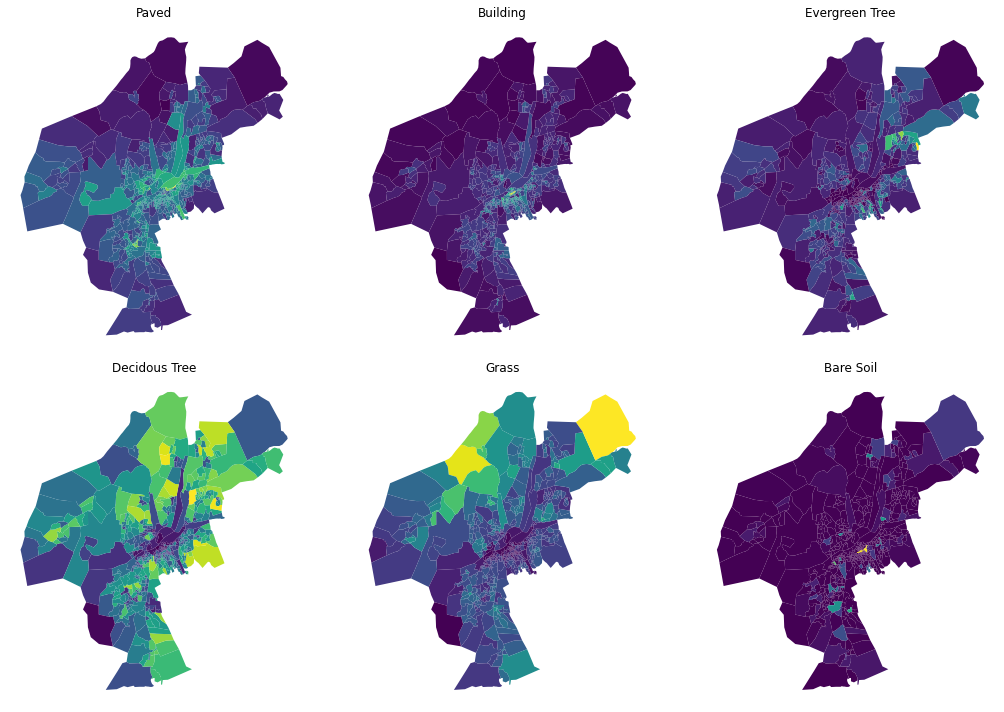

In [153]:
fig, axs = plt.subplots(2, 3, figsize = (15,10))

for col, r1,r2, in zip(raster_classes_name, [0,0,0,1,1,1], [0,1,2,0,1,2]):
    vectorfile.plot(column = col, ax = axs[r1,r2]).set_title(col)
    axs[r1,r2].set_axis_off()
    
plt.tight_layout()